In [2]:
# Bioinformatics
from pysam import VariantFile

# Data Analysis
import pandas as pd
import numpy as np
import math

# Plotting libraries
import matplotlib as mpl
import matplotlib.pyplot as plt
from matplotlib import cm
import matplotlib.ticker as ticker
from matplotlib.lines import Line2D
from matplotlib.patches import Patch

mpl.rcParams['figure.dpi'] = 300

In [3]:
# LENGTHS OF CHROMOSOMES
reference = "/media/urbe/MyADrive1/Antoine/19-11-21_VariantCalling_ARC/input/reference.fa"
fai = "/media/urbe/MyADrive1/Antoine/19-11-21_VariantCalling_ARC/input/reference.fa.fai"
lengths = {}
for line in open(fai, 'r') :
    s = line.strip().split()
    lengths[s[0]] = int(s[1])

In [4]:
# REPEATS DATAFRAME
repeats = "/media/urbe/MyBDrive1/Antoine/27-10-21_VariantCalling_MA/input/avaga.TEannotation.26-02-20.defragmentedDraftAnnot.bed"

reps = {"CHR":[], "START":[], "END":[]}
for line in open(repeats, "r") :
    s = line.strip().split("\t")
    reps["CHR"].append(s[0])
    reps["START"].append(int(s[1]))
    reps["END"].append(int(s[2]))
    
repdf = pd.DataFrame().from_dict(reps)

In [6]:
vcf_ME = "/media/urbe/MyBDrive1/Antoine/27-10-21_VariantCalling_MA/genotype_allsamples/merged.only_het.gets.bcf"

In [7]:
def getsampledf(vcf, sample) :
    
    # 1. read VCF
    dc = {
        "CHR":[],
        "POS":[],
        "ALS":[],
        "ADP":[],
        "AAF":[],
        "ODP":[],
        "OAF":[],
        #"HET":[],
    }

    vcf_in = VariantFile(vcf)  # auto-detect input format
    vcf_in.subset_samples(["ancestor", sample])

    # For record in sample
    for n, rec in enumerate(vcf_in) :
        if n % 10000000 == 0 :
            print("Elapsed records: {}".format(n))

        dc["CHR"].append(rec.chrom)
        dc["POS"].append(rec.pos)
        dc["ALS"].append(rec.alleles)
        
        #if len(rec.alleles) > 1 :
        #    dc["HET"].append(True)
        #else :
        #    dc["HET"].append(False)
        
        try :
            dc["ADP"].append(rec.samples["ancestor"]["DP"])
        except :
            dc["ADP"].append(None)
        
        try :
            dc["ODP"].append(rec.samples[sample]["DP"])
        except :
            dc["ODP"].append(None)
            
        try :
            AD = rec.samples["ancestor"]["AD"]
            dc["AAF"].append(float(max(AD)/sum(AD)))
        except :
            dc["AAF"].append(None)
            
        try :
            AD = rec.samples[sample]["AD"]
            dc["OAF"].append(float(max(AD)/sum(AD)))
        except :
            dc["OAF"].append(None)

    vcf_in.close()
    
    return pd.DataFrame().from_dict(dc)

In [8]:
%%time

sample = "H4A4_50G"
df50 = getsampledf(vcf=vcf_ME, sample=sample)
sample = "H4A4"
df100 = getsampledf(vcf=vcf_ME, sample=sample)

Elapsed records: 0
Elapsed records: 0
CPU times: user 1min 42s, sys: 5.1 s, total: 1min 47s
Wall time: 1min 47s


In [9]:
df50

,CHR,POS,ALS,ADP,AAF,ODP,OAF
0,Chrom_3,2228,"(G, A)",13.0,0.846154,14.0,0.928571
1,Chrom_3,2271,"(C, T)",17.0,0.823529,16.0,0.937500
2,Chrom_3,2399,"(G, T)",36.0,0.805556,34.0,0.941176
3,Chrom_3,2428,"(T, C)",46.0,0.847826,41.0,0.951220
4,Chrom_3,2444,"(G, A)",49.0,0.857143,44.0,0.931818
...,...,...,...,...,...,...,...
2217680,Chrom_6,13888600,"(T, C)",165.0,0.818182,153.0,1.000000
2217681,Chrom_6,13888612,"(T, G)",160.0,0.825000,153.0,1.000000
2217682,Chrom_6,13888614,"(A, T)",160.0,0.825000,153.0,1.000000
2217683,Chrom_6,13888623,"(C, CCAAGGAATGACAAATCTAAAAT)",158.0,1.000000,156.0,1.000000


In [10]:
df = pd.merge(left=df100, right=df50, on=["CHR", "POS", "ADP", "AAF"], how='inner', suffixes=["_100", "_50"])
df

,CHR,POS,ALS_100,ADP,AAF,ODP_100,OAF_100,ALS_50,ODP_50,OAF_50
0,Chrom_3,2228,"(G, A)",13.0,0.846154,8.0,0.875000,"(G, A)",14.0,0.928571
1,Chrom_3,2271,"(C, T)",17.0,0.823529,9.0,0.888889,"(C, T)",16.0,0.937500
2,Chrom_3,2399,"(G, T)",36.0,0.805556,23.0,0.913043,"(G, T)",34.0,0.941176
3,Chrom_3,2428,"(T, C)",46.0,0.847826,27.0,0.925926,"(T, C)",41.0,0.951220
4,Chrom_3,2444,"(G, A)",49.0,0.857143,31.0,0.967742,"(G, A)",44.0,0.931818
...,...,...,...,...,...,...,...,...,...,...
2217680,Chrom_6,13888600,"(T, C)",165.0,0.818182,168.0,1.000000,"(T, C)",153.0,1.000000
2217681,Chrom_6,13888612,"(T, G)",160.0,0.825000,171.0,1.000000,"(T, G)",153.0,1.000000
2217682,Chrom_6,13888614,"(A, T)",160.0,0.825000,171.0,0.994152,"(A, T)",153.0,1.000000
2217683,Chrom_6,13888623,"(C, CCAAGGAATGACAAATCTAAAAT)",158.0,1.000000,173.0,1.000000,"(C, CCAAGGAATGACAAATCTAAAAT)",156.0,1.000000


In [11]:
del df100
del df50

### Histograms

In [12]:
mode_dp_anc = df.query("CHR != 'Chrom_1'")["ADP"].mode()[0]
mode_dp_mid = df.query("CHR != 'Chrom_1'")["ODP_50"].mode()[0]
mode_dp_end = df.query("CHR != 'Chrom_1'")["ODP_100"].mode()[0]

In [13]:
cycle = plt.rcParams['axes.prop_cycle'].by_key()['color']

In [14]:
hist_adp_C1, bin_adp_C1 = np.histogram(df[["CHR","ADP"]].query("CHR == 'Chrom_1'")["ADP"], range=(0,800), bins=80, density=True)
hist_adp_not_C1, bin_adp_not_C1 = np.histogram(df[["CHR","ADP"]].query("CHR != 'Chrom_1'")["ADP"], range=(0,800), bins=80, density=True)

In [15]:
hist_mid_dp_C1, bin_mid_dp_C1 = np.histogram(df[["CHR","ODP_50"]].query("CHR == 'Chrom_1'")["ODP_50"], range=(0,800), bins=80, density=True)
hist_mid_dp_not_C1, bin_mid_dp_not_C1 = np.histogram(df[["CHR","ODP_50"]].query("CHR != 'Chrom_1'")["ODP_50"], range=(0,800), bins=80, density=True)

In [16]:
hist_end_dp_C1, bin_end_dp_C1 = np.histogram(df[["CHR","ODP_100"]].query("CHR == 'Chrom_1'")["ODP_100"], range=(0,800), bins=80, density=True)
hist_end_dp_not_C1, bin_end_dp_not_C1 = np.histogram(df[["CHR","ODP_100"]].query("CHR != 'Chrom_1'")["ODP_100"], range=(0,800), bins=80, density=True)

In [17]:
hist_af_C1, bin_af_C1 = np.histogram(df[["CHR","AAF"]].query("CHR == 'Chrom_1'")["AAF"], range=(0.5,1.01), bins=50, density=True)
hist_af_not_C1, bin_af_not_C1 = np.histogram(df[["CHR","AAF"]].query("CHR != 'Chrom_1'")["AAF"], range=(0.5,1.01), bins=50, density=True)

In [18]:
hist_mf_C1, bin_mf_C1 = np.histogram(df[["CHR","OAF_50"]].query("CHR == 'Chrom_1'")["OAF_50"], range=(0.5,1.01), bins=50, density=True)
hist_mf_not_C1, bin_mf_not_C1 = np.histogram(df[["CHR","OAF_50"]].query("CHR != 'Chrom_1'")["OAF_50"], range=(0.5,1.01), bins=50, density=True)

In [19]:
hist_ef_C1, bin_ef_C1 = np.histogram(df[["CHR","OAF_100"]].query("CHR == 'Chrom_1'")["OAF_100"], range=(0.5,1.01), bins=50, density=True)
hist_ef_not_C1, bin_ef_not_C1 = np.histogram(df[["CHR","OAF_100"]].query("CHR != 'Chrom_1'")["OAF_100"], range=(0.5,1.01), bins=50, density=True)

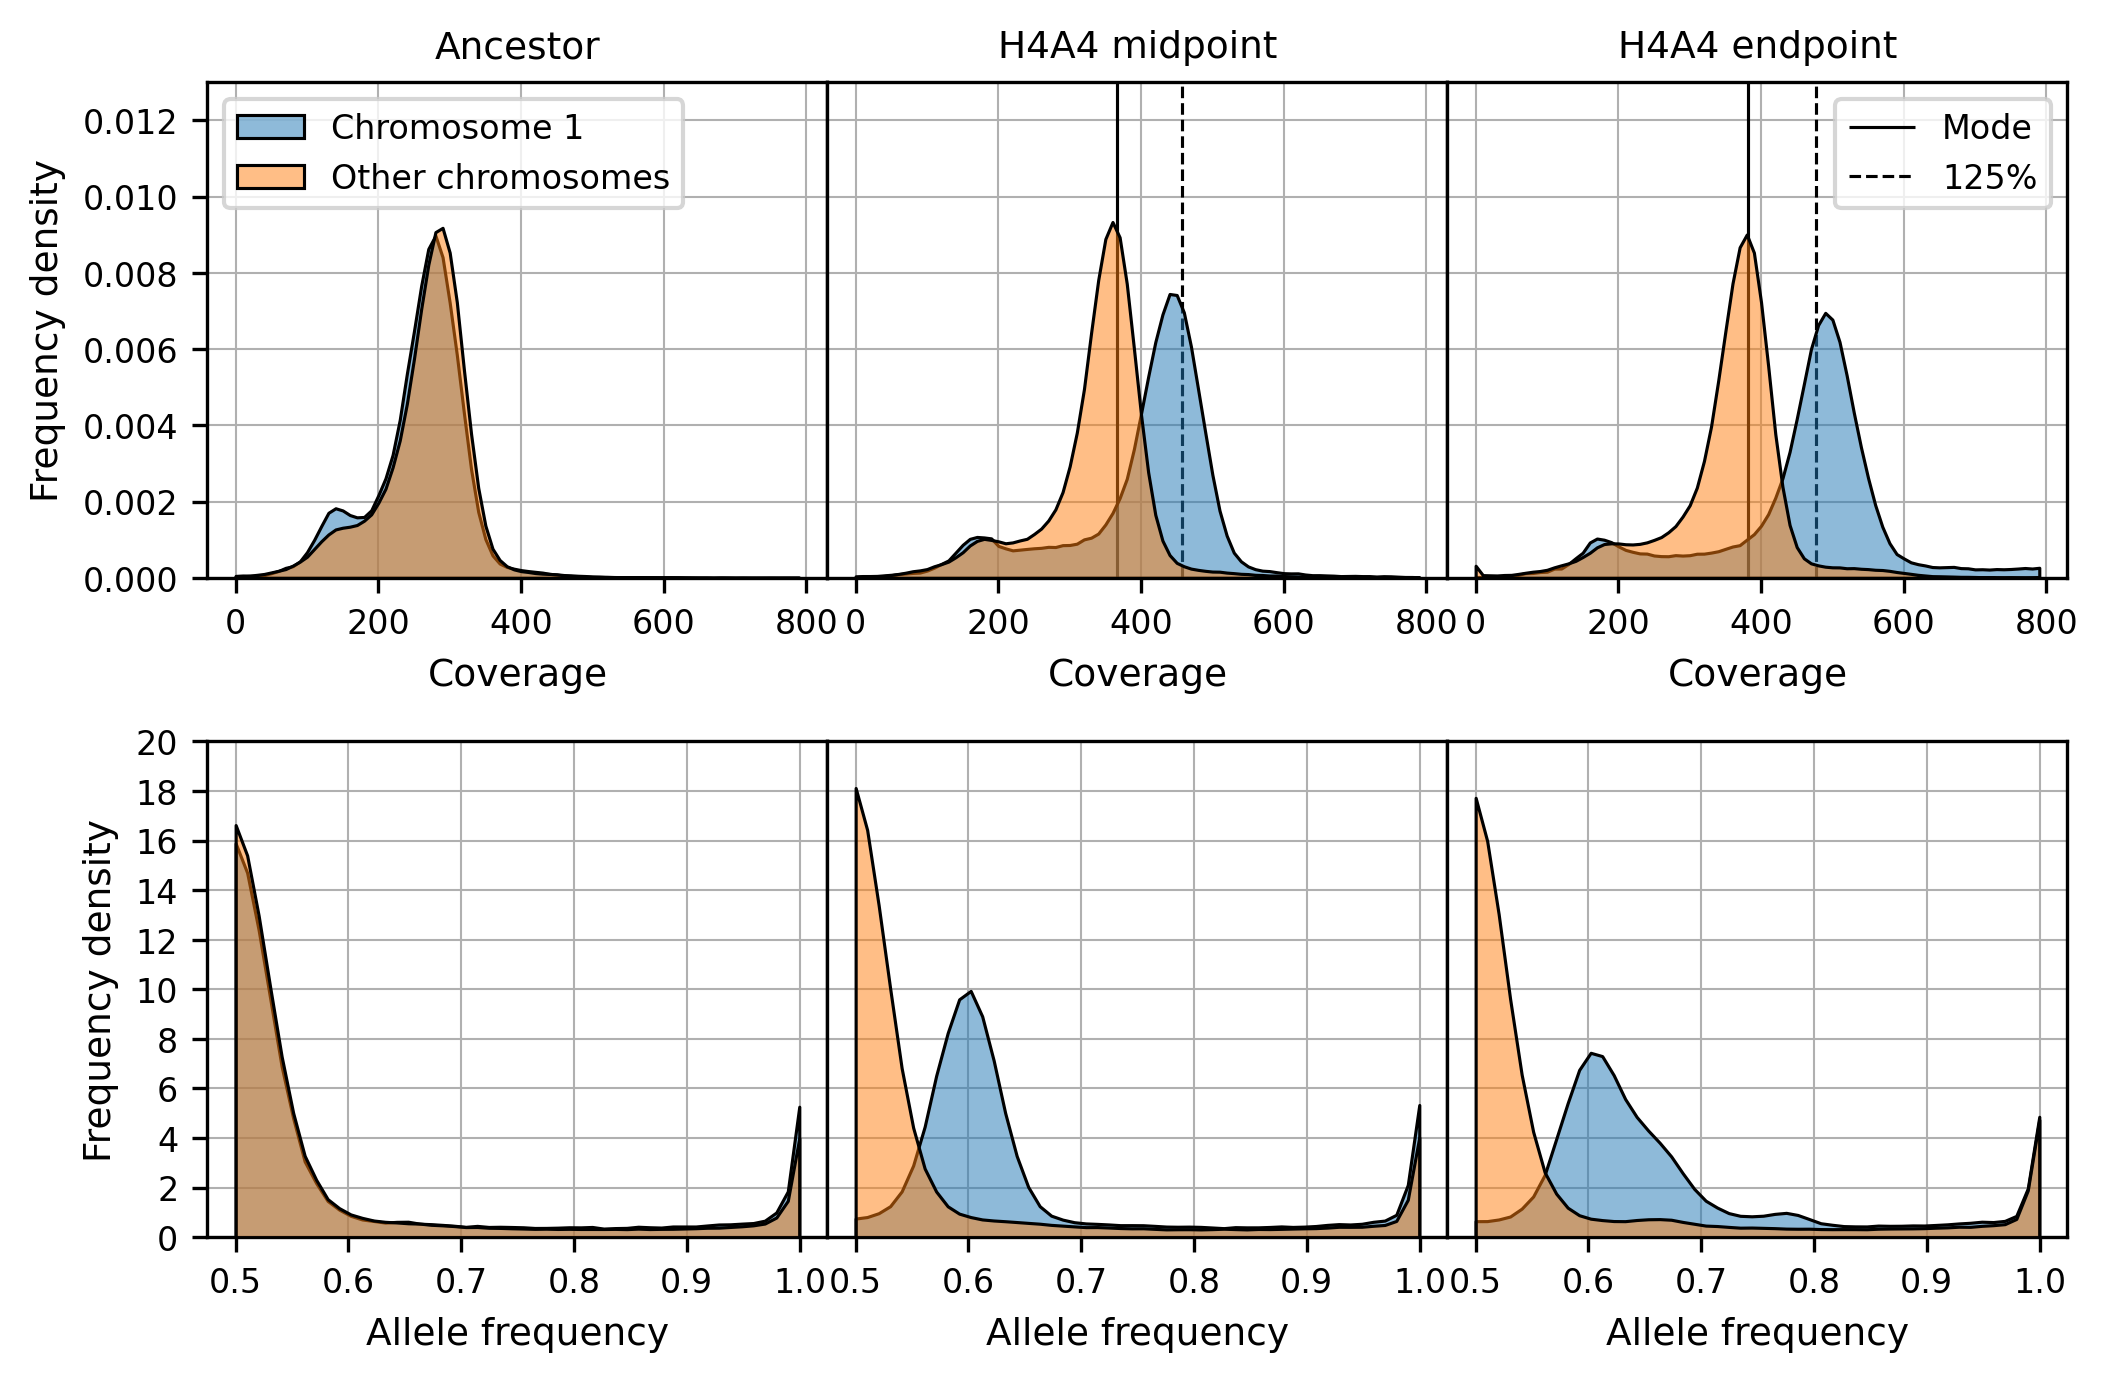

In [22]:
fig, axs = plt.subplots(ncols=3, nrows=2, figsize=(8,5))

axs[0,0].fill_between(bin_adp_C1[:-1], 0, hist_adp_C1, facecolor=cycle[0]+"80", ec="k", zorder=10, lw=0.75, label="Chromosome 1")
axs[0,0].fill_between(bin_adp_not_C1[:-1], 0, hist_adp_not_C1, facecolor=cycle[1]+"80", ec="k", zorder=10, lw=0.75, label="Other chromosomes")
axs[0,0].legend(fontsize=8, loc="upper left", frameon=True)

axs[0,1].fill_between(bin_mid_dp_C1[:-1], 0, hist_mid_dp_C1, facecolor=cycle[0]+"80", ec="k", lw=0.75, zorder=10)
axs[0,1].fill_between(bin_mid_dp_not_C1[:-1], 0, hist_mid_dp_not_C1, facecolor=cycle[1]+"80", ec="k", lw=0.75, zorder=10)
axs[0,1].vlines([mode_dp_mid], ymin=0, ymax=0.013, color="k", lw=0.75, linestyle="-", label="Mode")
axs[0,1].vlines([1.25*mode_dp_mid], ymin=0, ymax=0.013, color="k", lw=0.75, linestyle="--", label="125%")
#axs[0,1].legend(fontsize=8)

axs[0,2].fill_between(bin_end_dp_C1[:-1], 0, hist_end_dp_C1, facecolor=cycle[0]+"80", ec="k", lw=0.75, zorder=10)
axs[0,2].fill_between(bin_end_dp_not_C1[:-1], 0, hist_end_dp_not_C1, facecolor=cycle[1]+"80", ec="k", lw=0.75, zorder=10)
axs[0,2].vlines([mode_dp_end], ymin=0, ymax=0.013, color="k", lw=0.75, linestyle="-", label="Mode")
axs[0,2].vlines([1.25*mode_dp_end], ymin=0, ymax=0.013, color="k", lw=0.75, linestyle="--", label="125%")
axs[0,2].legend(fontsize=8)

axs[1,0].fill_between(bin_af_C1[:-1], 0, hist_af_C1, facecolor=cycle[0]+"80", ec="k", lw=0.75, zorder=10)
axs[1,0].fill_between(bin_af_not_C1[:-1], 0, hist_af_not_C1, facecolor=cycle[1]+"80", ec="k", lw=0.75, zorder=10)

axs[1,1].fill_between(bin_mf_C1[:-1], 0, hist_mf_C1, facecolor=cycle[0]+"80", ec="k", lw=0.75, zorder=10)
axs[1,1].fill_between(bin_mf_not_C1[:-1], 0, hist_mf_not_C1, facecolor=cycle[1]+"80", ec="k", lw=0.75, zorder=10)

axs[1,2].fill_between(bin_ef_C1[:-1], 0, hist_ef_C1, facecolor=cycle[0]+"80", ec="k", lw=0.75, zorder=10)
axs[1,2].fill_between(bin_ef_not_C1[:-1], 0, hist_ef_not_C1, facecolor=cycle[1]+"80", ec="k", lw=0.75, zorder=10)

for axi in axs.flatten() :
    axi.grid(zorder=1, lw=0.5)
    axi.tick_params(axis="both", labelsize=8)
    #axi.tick_params(axis="x", labelsize=8)

upper_yticks = np.arange(0.0,0.013, 0.002)
for axi in axs[0,0:] :
    axi.set_ylim(0,0.013)
    axi.set_yticks(upper_yticks)
    axi.set_xlabel("Coverage", fontsize=9)

for axi in axs[0,1:] :
    axi.tick_params(axis="y", length=0)
    axi.set_yticklabels(["" for i in upper_yticks])
    
lower_yticks = np.arange(0,21,2)
for axi in axs[1,0:] :
    axi.set_ylim(0,20)
    axi.set_yticks(lower_yticks)
    axi.set_xticks(np.arange(0.5,1.01,0.1))
    axi.set_xlabel("Allele frequency", fontsize=9)

for axi in axs[1,1:] :
    axi.tick_params(axis="y", length=0)
    axi.set_yticklabels(["" for i in lower_yticks])

axs[0,0].set_title("Ancestor", fontsize=9)
axs[0,1].set_title("H4A4 midpoint", fontsize=9)
axs[0,2].set_title("H4A4 endpoint", fontsize=9)

axs[0,0].set_ylabel("Frequency density", fontsize=9)
axs[1,0].set_ylabel("Frequency density", fontsize=9)

plt.subplots_adjust(wspace=0, hspace=0.33)
plt.show()

# K-MERS

In [24]:
import os
# mx files are results of kat comp <library> <reference AV20>
mx_dir = "/media/urbe/MyADrive1/Antoine/13-12-2021_Analysis_GR_MA"
mx_h4a4_mid = os.path.join(mx_dir, "GC1002741-main.mx")
mx_h4a4_end = os.path.join(mx_dir, "GC078304-main.mx")
mx_ctl = os.path.join(mx_dir, "GC1002743-main.mx")

In [25]:
mx1 = np.loadtxt(mx_h4a4_mid)
mx1 = np.transpose(mx1)
mx2 = np.loadtxt(mx_h4a4_end)
mx2 = np.transpose(mx2)
mx3 = np.loadtxt(mx_ctl)
mx3 = np.transpose(mx3)

In [26]:
bands = [0,1]
nm1 = np.zeros((len(bands), len(mx1[0])))
i = 0
for b in bands:
    nm1[i] = mx1[b,:]
    i += 1
    
nm2 = np.zeros((len(bands), len(mx2[0])))
i = 0
for b in bands:
    nm2[i] = mx2[b,:]
    i += 1
    
nm3 = np.zeros((len(bands), len(mx3[0])))
i = 0
for b in bands:
    nm3[i] = mx3[b,:]
    i += 1

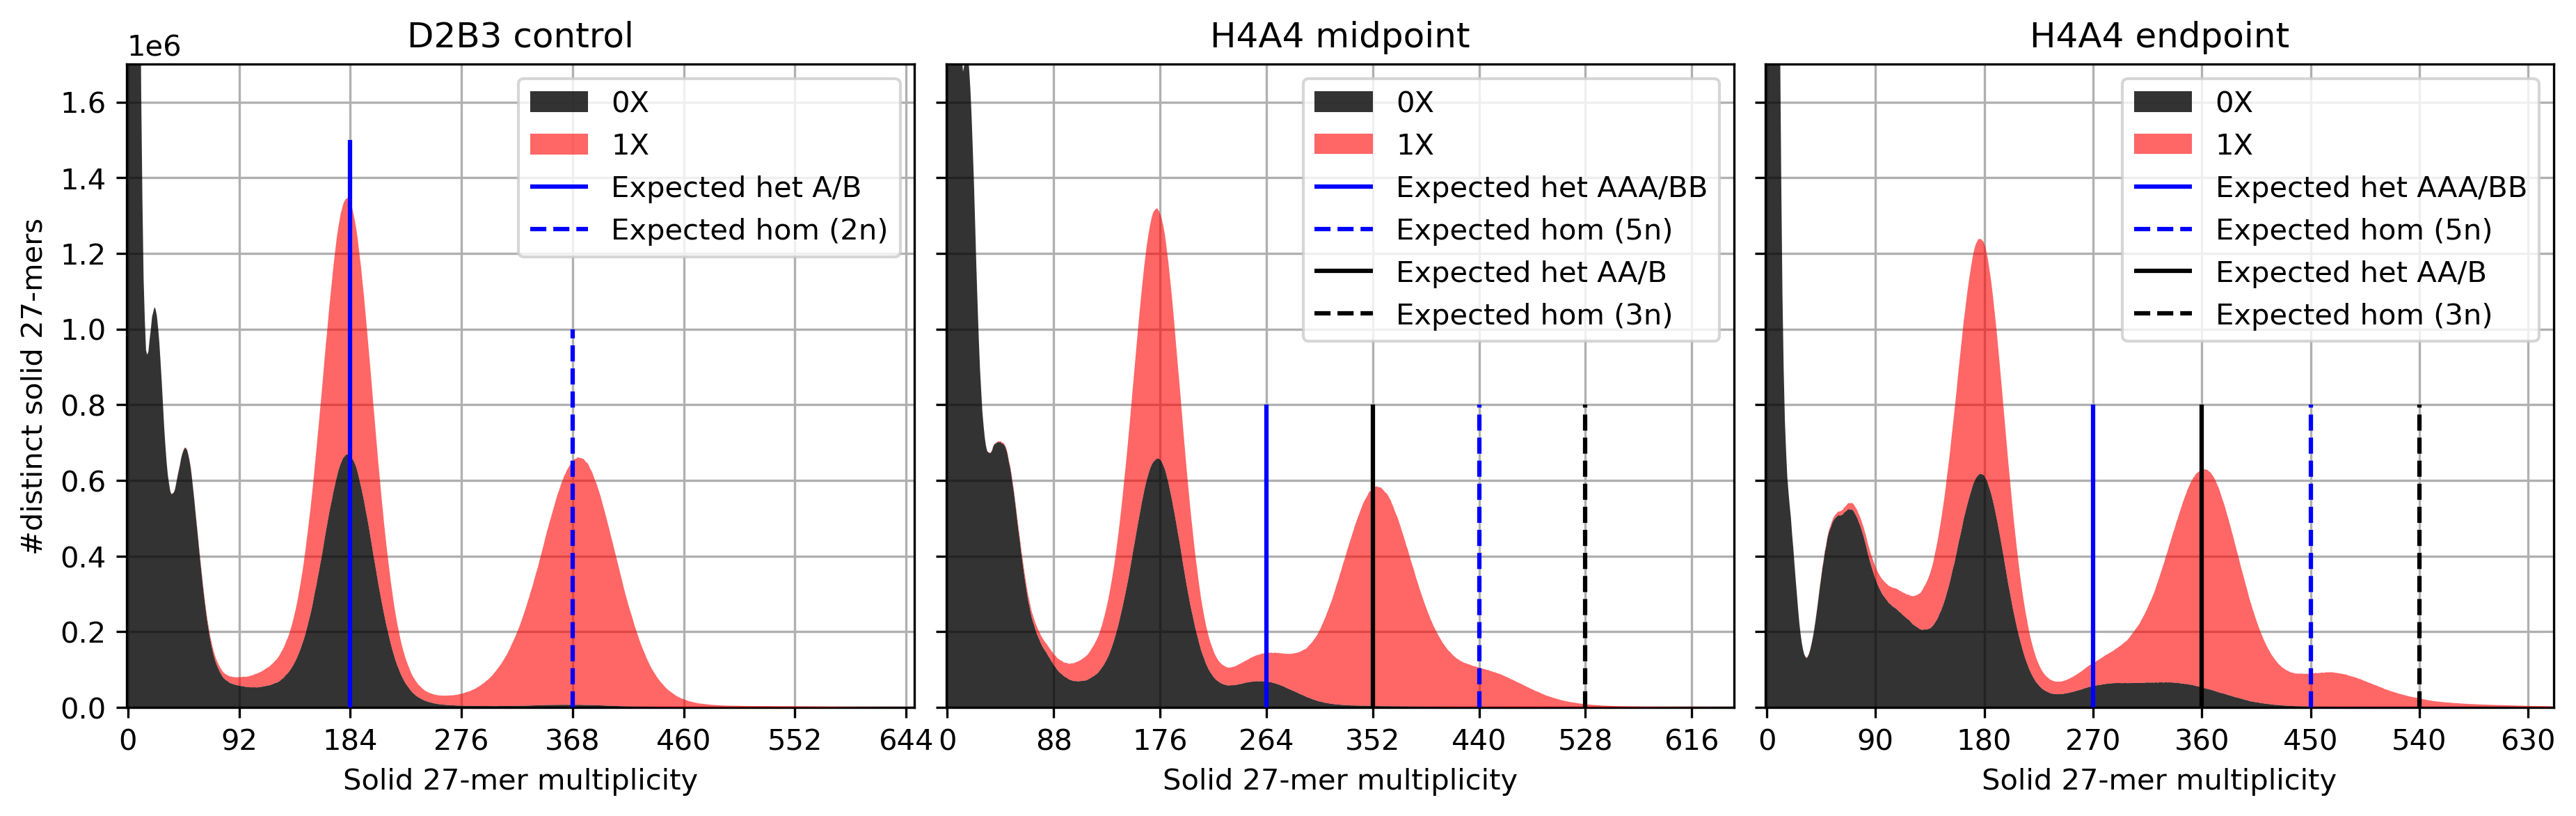

In [27]:
colors = [(0,0,0,0.8), (1,0,0,0.6)]

x = list(range(650))
nm1 = nm1[:,:650]
nm2 = nm2[:,:650]
nm3 = nm3[:,:650]

fig, axs = plt.subplots(nrows=1, ncols=3, sharey=True, figsize=(15,4))

ax = axs[0]
for i in range(len(bands)) :
    y_bottom = np.squeeze(np.asarray(np.sum(nm3[:i,:], 0)))
    y = np.squeeze(np.asarray(nm3[i,:])) + y_bottom
    ax.fill_between(
        x, y_bottom, y, label="{}X".format(i),
        facecolor=colors[i%len(colors)], zorder=5
    )
    
ex1 = 184
ex2 = 184 * 2
ax.vlines(x=[ex1], ymin=0, ymax=1500000, color="b", label="Expected het A/B", zorder=10)
ax.vlines(x=[ex2], ymin=0, ymax=1000000, color="b", label="Expected hom (2n)", linestyle="dashed", zorder=10)

ax.set_ylim(0, 1700000)
ax.set_xlim(-1, 651)
xticks = [i*92 for i in range(8)]
ax.set_xticks(xticks)
ax.grid(zorder=1)
ax.legend()

# ============================================================== #

ax = axs[1]
for i in range(len(bands)) :
    y_bottom = np.squeeze(np.asarray(np.sum(nm1[:i,:], 0)))
    y = np.squeeze(np.asarray(nm1[i,:])) + y_bottom
    ax.fill_between(
        x, y_bottom, y, label="{}X".format(i),
        facecolor=colors[i%len(colors)], zorder=5
    )

ex1 = 176 * 1.5
ex2 = 352 * 1.25
ax.vlines(x=[ex1], ymin=0, ymax=800000, color="b", label="Expected het AAA/BB", zorder=10)
ax.vlines(x=[ex2], ymin=0, ymax=800000, color="b", label="Expected hom (5n)", linestyle="dashed", zorder=10)

ex1 = 176 * 2.0
ex2 = 352 * 1.5
ax.vlines(x=[ex1], ymin=0, ymax=800000, color="k", label="Expected het AA/B", zorder=10)
ax.vlines(x=[ex2], ymin=0, ymax=800000, color="k", label="Expected hom (3n)", linestyle="dashed", zorder=10)


ax.set_ylim(0, 1700000)
ax.set_xlim(-1, 651)
xticks = [i*88 for i in range(8)]
ax.set_xticks(xticks)
ax.grid(zorder=1)
ax.legend()

# ============================================================== #

ax = axs[2]
for i in range(len(bands)) :
    y_bottom = np.squeeze(np.asarray(np.sum(nm2[:i,:], 0)))
    y = np.squeeze(np.asarray(nm2[i,:])) + y_bottom
    ax.fill_between(
        x, y_bottom, y, label="{}X".format(i),
        facecolor=colors[i%len(colors)], zorder=5
    )
    
ex1 = 180 * 1.5
ex2 = 360 * 1.25
ax.vlines(x=[ex1], ymin=0, ymax=800000, color="b", label="Expected het AAA/BB", zorder=10)
ax.vlines(x=[ex2], ymin=0, ymax=800000, color="b", label="Expected hom (5n)", linestyle="dashed", zorder=10)

ex1 = 180 * 2.0
ex2 = 360 * 1.5
ax.vlines(x=[ex1], ymin=0, ymax=800000, color="k", label="Expected het AA/B", zorder=10)
ax.vlines(x=[ex2], ymin=0, ymax=800000, color="k", label="Expected hom (3n)", linestyle="dashed", zorder=10)
    
ax.set_ylim(0, 1700000)
ax.set_xlim(-1, 651)
xticks = [i*90 for i in range(8)]
ax.set_xticks(xticks)
ax.grid(zorder=1)
ax.legend()

axs[0].set_title("D2B3 control")
axs[1].set_title("H4A4 midpoint")
axs[2].set_title("H4A4 endpoint")

axs[0].set_ylabel("#distinct solid 27-mers")
for i in range(3) :
    axs[i].set_xlabel("Solid 27-mer multiplicity")

plt.subplots_adjust(wspace=0.04)
    
plt.show()